## Modeling of bank failures by FDIC 

**Instructions:**
- You will be using Python 3.
- Avoid using for-loops and while-loops, unless you are explicitly told to do so.
- Do not modify the (# GRADED FUNCTION [function name]) comment in some cells. Your work would not be graded if you change this. Each cell containing that comment should only contain one function.
- After coding your function, run the cell right below it to check if your result is correct.
- The token generated by Coursera (COURSERA_TOKEN) expires every <b>30 minutes</b>. It is advisable to always work with the most recent generated token so as to avoid any submission related errors. If you receive such error messages, rerun the cells containing your code and the GRADED FUNCTION in the same order. 


## About iPython Notebooks ##

iPython Notebooks are interactive coding environments embedded in a webpage. You will be using iPython notebooks in this class. You only need to write code between the ### START CODE HERE ### and ### END CODE HERE ### comments. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook. 

We will often specify "(≈ X lines of code)" in the comments to tell you about how much code you need to write. It is just a rough estimate, so don't feel bad if your code is longer or shorter.

In [1]:
import pandas as pd
import numpy as np
import time

import os
import functools
import math
import random
import sys, getopt
import sklearn

sys.path.append("..")
import grading

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass
print('scikit-learn version:', sklearn.__version__)

scikit-learn version: 0.18.2


In [2]:
### ONLY FOR GRADING. DO NOT EDIT ###
submissions=dict()
assignment_key="7VcH6P8REeeRWA42vRAjYg" 
all_parts=["o5YYT", "2cHUA", "Mxrav", "JFNf3", "ivHQa"]
### ONLY FOR GRADING. DO NOT EDIT ###

In [3]:
# token expires every 30 min
COURSERA_TOKEN = "BLc2lREFEhVAxKXj" # the key provided to the Student under his/her email on submission page
COURSERA_EMAIL = "sohaum.ghosh.csbs25@heritageit.edu.in" # the email

In [4]:
# common cell - share this across notebooks
state_cols = ['log_TA','NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'REO_to_TA', 
              'ALLL_to_TL', 'core_deposits_to_TA', 'brokered_deposits_to_TA', 
              'liquid_assets_to_TA', 'loss_provision_to_TL', 'NIM', 'assets_growth']

all_MEVs = np.array(['term_spread',
                    'stock_mkt_growth',
                    'real_gdp_growth',
                    'unemployment_rate_change',
                    'treasury_yield_3m',
                    'bbb_spread',
                    'bbb_spread_change'])

MEV_cols = all_MEVs.tolist()

next_state_cols = ['log_TA_plus_1Q','NI_to_TA_plus_1Q', 'Equity_to_TA_plus_1Q', 'NPL_to_TL_plus_1Q', 'REO_to_TA_plus_1Q', 
                   'ALLL_to_TL_plus_1Q', 'core_deposits_to_TA_plus_1Q', 'brokered_deposits_to_TA_plus_1Q', 
                   'liquid_assets_to_TA_plus_1Q', 'loss_provision_to_TL_plus_1Q', 
                   'ROA_plus_1Q', 
                   'NIM_plus_1Q', 
                   'assets_growth_plus_1Q', 
                   'FDIC_assessment_base_plus_1Q_n']

In [5]:
df_train = pd.read_hdf('../readonly/df_train_FDIC_defaults_1Y.h5', key='df')
df_test = pd.read_hdf('../readonly/df_test_FDIC_defaults_1Y.h5', key='df')
df_data = pd.read_hdf('../readonly/data_adj_FDIC_small.h5', key='df')
df_closure_learn = pd.read_hdf('../readonly/df_FDIC_learn.h5',key='df')
print(df_closure_learn.index.names)

Opening ../readonly/df_train_FDIC_defaults_1Y.h5 in read-only mode
Opening ../readonly/df_test_FDIC_defaults_1Y.h5 in read-only mode
Opening ../readonly/data_adj_FDIC_small.h5 in read-only mode
Opening ../readonly/df_FDIC_learn.h5 in read-only mode
['IDRSSD', 'date']


## Construct training and testing datasets for logistic regression

In [ ]:
df_test.plot(x=state_cols[0], y='defaulter', kind='scatter')

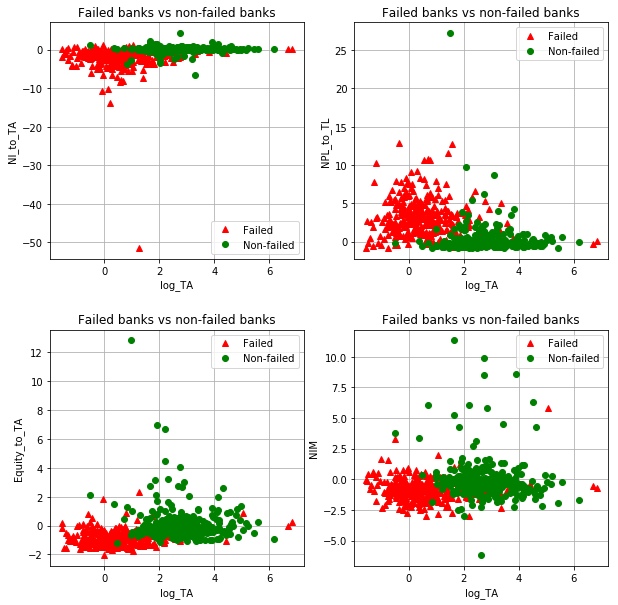

In [6]:
# Plot 4 scatter plots together

# log_TA / NI_to_TA
# log_TA / NPL_to_TL
# log_TA / Equity_to_TA
# log_TA /ROA

first_indx = [0, 0, 0, 0]
second_indx = [1, 3, 2, 10]

X_train = df_train[state_cols].values
y_train = df_train.defaulter.values # .reshape(-1,1)

num_plots = 4
if num_plots % 2 == 0:
    f, axs = plt.subplots(num_plots // 2, 2)
else:
    f, axs = plt.subplots(num_plots// 2 + 1, 2)
    
f.subplots_adjust(hspace=.3)

f.set_figheight(10.0)
f.set_figwidth(10.0)
    
for i in range(num_plots):
    if i % 2 == 0:
        first_idx = i // 2
        second_idx = 0
    else:
        first_idx = i // 2
        second_idx = 1
        
    axs[first_idx,second_idx].plot(X_train[y_train == 1.0, first_indx[i]], 
                                   X_train[y_train == 1.0, second_indx[i]], 'r^', label="Failed")
    axs[first_idx,second_idx].plot(X_train[y_train == 0.0, first_indx[i]], 
                                   X_train[y_train == 0.0, second_indx[i]], 'go',label="Non-failed") 
    
    axs[first_idx, second_idx].legend()
    axs[first_idx, second_idx].set_xlabel('%s' % state_cols[first_indx[i]])
    axs[first_idx, second_idx].set_ylabel('%s' % state_cols[second_indx[i]])
    axs[first_idx, second_idx].set_title('Failed banks vs non-failed banks')
    axs[first_idx, second_idx].grid(True)
    
if num_plots % 2 != 0:
    f.delaxes(axs[i // 2, 1])
    
# plt.savefig('Failed_vs_nonfailed_rr_plot.png')

In [7]:
def calc_metrics(model, df_test, y_true, threshold=0.5):
    """
    Arguments:
    model - trained model such as DecisionTreeClassifier, etc.
    df_test - Data Frame of predictors
    y_true - True binary labels in range {0, 1} or {-1, 1}. If labels are not binary, pos_label should be explicitly given.
    """
    if model is None:
        return 0., 0., 0.
    
    # prediction 
    predicted_sm = model.predict(df_test, linear=False)
    predicted_binary = (predicted_sm > threshold).astype(int)

    # print(predicted_sm.shape, y_true.shape)
    fpr, tpr, _ = metrics.roc_curve(y_true, predicted_sm, pos_label=1)
    
    # compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    roc_auc = metrics.auc(fpr, tpr)
    ks = np.max(tpr - fpr) # Kolmogorov - Smirnov test

    # note that here teY[:,0] is the same as df_test.default_within_1Y
    accuracy_score = metrics.accuracy_score(y_true, predicted_binary)
    
    # equivalently, Area Under the ROC Curve could be computed as:
    # compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    # auc_score = metrics.roc_auc_score(y_true, predicted_sm)

    try:
        plt.title('Logistic Regression ROC curve')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')

        # plt.savefig('ROC_curve_1.png')
        plt.show()
    except:
        pass

    return roc_auc, accuracy_score, ks

In [8]:
def make_test_train(df_train, df_test, choice=0, predict_within_1Y=False):
    """
    make the train and test datasets
    Arguments:
    choice - an integer 0 or -1. Controls selection of predictors. 
    Add tangible equity and assessment base as predictors

    predict_within_1Y - boolean  if True, predict defaults within one year
    Return:
        a tuple of:
        - training data set predictors, np.array
        - training data set : variable to predict, np.array
        - test data set : variable to predict, np.array
        - predictor variable names
    """
    
    if choice == -1: # only state cols
        predictors = state_cols
    elif choice == 0:  # original variables
        predictors = state_cols + MEV_cols 

    trX = df_train[predictors].values
    teX = df_test[predictors].values
    num_features = len(predictors)    
    num_classes = 2

    if predict_within_1Y == True:
        trY = df_train[['default_within_1Y','no_default_within_1Y']].values
        teY = df_test[['default_within_1Y','no_default_within_1Y']].values
    else:
        trY = df_train[['defaulter','non_defaulter']].values
        teY = df_test[['defaulter','non_defaulter']].values
    return trX, trY, teX, teY, predictors

In [9]:
# look at correlations
df_train[MEV_cols].corr()

,term_spread,stock_mkt_growth,real_gdp_growth,unemployment_rate_change,treasury_yield_3m,bbb_spread,bbb_spread_change
term_spread,1.000000,0.002993,-0.145941,0.299972,-0.633991,0.392349,-0.465767
stock_mkt_growth,0.002993,1.000000,-0.148941,0.461947,-0.081915,0.417379,-0.762702
real_gdp_growth,-0.145941,-0.148941,1.000000,-0.825802,0.041596,-0.820518,0.385007
unemployment_rate_change,0.299972,0.461947,-0.825802,1.000000,0.034355,0.881223,-0.657093
treasury_yield_3m,-0.633991,-0.081915,0.041596,0.034355,1.000000,-0.272072,0.290414
bbb_spread,0.392349,0.417379,-0.820518,0.881223,-0.272072,1.000000,-0.716249
bbb_spread_change,-0.465767,-0.762702,0.385007,-0.657093,0.290414,-0.716249,1.000000


## Logistic regression with statsmodels

### Part 1
Perform logistic regression using **cols_to_use** as predictors. Use df_train pandas DataFrame as training data set, and df_test pandas DataDrame as testing data set to perform prediction based on the already trained model. Utilize statsmodels package. The result of fitting logistic regression should be assigned to variable named **model**

In [10]:
import statsmodels.api as sm
from sklearn import metrics

# Combine state_cols, MEV_cols, and add a constant for the intercept
cols_to_use = state_cols + MEV_cols + ['const']
model = None

# Prepare the training dataset by adding a constant
df_train['const'] = 1

### START CODE HERE ### (≈ 3 lines of code)
# Fit the logistic regression model
model = sm.Logit(df_train['defaulter'], df_train[cols_to_use]).fit()

# Print the summary of the model to check coefficients and statistics
print(model.summary())
### END CODE HERE ###

Optimization terminated successfully.
         Current function value: 0.159379
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              defaulter   No. Observations:                  641
Model:                          Logit   Df Residuals:                      621
Method:                           MLE   Df Model:                           19
Date:                Mon, 28 Oct 2024   Pseudo R-squ.:                  0.7699
Time:                        00:39:31   Log-Likelihood:                -102.16
converged:                       True   LL-Null:                       -444.03
                                        LLR p-value:                1.006e-132
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
log_TA                      -1.4917      0.192     -7.757      0.000      -1.869

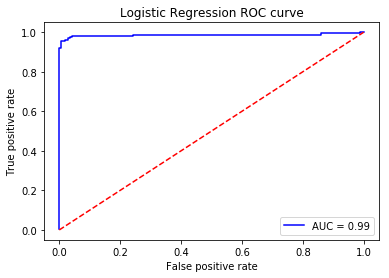

Accuracy score 0.969789
AUC score 0.986043
Kolmogorov-Smirnov statistic 0.950639


In [11]:
# Initialize an empty array to hold predicted values
predicted_sm = np.array([])

### START CODE HERE ### (≈ 3 lines of code)
# Ensure the test data has a constant column
df_test['const'] = 1

# Use the model to predict probabilities on the test data
predicted_sm = model.predict(df_test[cols_to_use])
### END CODE HERE ###

threshold = 0.5
predicted_binary = (predicted_sm > threshold).astype(int)

# Calculate metrics using the predictions
auc_score, accuracy_score, ks = calc_metrics(model, df_test[cols_to_use], df_test.defaulter)

print('Accuracy score %f' % accuracy_score)
print('AUC score %f' % auc_score)
print('Kolmogorov-Smirnov statistic %f' % ks)

# Note that here teY[:,0] is the same as df_test.default_within_1Y

In [12]:
### GRADED PART (DO NOT EDIT) ###
part_1=[accuracy_score, auc_score, ks]

try:
    part1 = " ".join(map(repr, part_1))
except TypeError:
    part1 = repr(part_1)    
    
submissions[all_parts[0]]=part1
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[0],all_parts,submissions)
[accuracy_score, auc_score, ks]
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


[0.96978851963746227, 0.98604311289733282, 0.95063938618925836]

## Logistic Regression with sklearn

### Part 2 
In Part 2 you will use scikit-learn to perform logistic regression using the same training and test datasets.
Once the model is trained using trX, thisTrY, test it using teX, thisTeY and compute logistic regression score.

- Use **"l1"** penalty
- Set inverse of regularization strength to **1000.0**; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- Set tolerance to **1e-6**

In [13]:
from sklearn import linear_model

# Prepare training and testing data
trX, trY, teX, teY, predictors = make_test_train(df_train, df_test)
lr_score = 0.
thisTrY = trY[:, 0]  # Use the first column for training labels
thisTeY = teY[:, 0]  # Use the first column for testing labels

# Instantiate the Logistic Regression model with the specified parameters
logistic = linear_model.LogisticRegression(
    penalty="l1",       # L1 penalty
    C=1/1000.0,        # Inverse of regularization strength
    tol=1e-6,          # Tolerance for stopping criteria
    random_state=42    # For reproducibility
)

# Fit the model on the training data
result = logistic.fit(trX, thisTrY)

# Compute the score on the test set
lr_score = logistic.score(teX, thisTeY)

### END CODE HERE ###

print('LogisticRegression score: %f' % lr_score)

LogisticRegression score: 0.513595


In [14]:
### GRADED PART (DO NOT EDIT) ###
part2=str(lr_score)   
submissions[all_parts[1]]=part2
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:2],all_parts,submissions)
lr_score
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


0.51359516616314205

**Instructions:**
In this part you will again use scikit learn logistic regression but with different set of predictors. This will be a smaller set of predictor variables based on the analysis of P-values from the logistic regression. Use cols_to_use as predictors in df_train and df_test data sets. Use  **defaulter** column as something to predict.

Initialize reference to the logistic regression model **logistic** with an instance of appropriate class from  scikit learn module and let **result** be the result of fitting the model to the training data set.

Just as before initialize the model with the following parameters:
- Use **"l1"** penalty
- Set inverse of regularization strength to **1000.0**; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- Set tolerance to **1e-6**

In [47]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
# Do Logistic Regression with a smaller number of predictor, based on analysis of P-values 
# for the logistic regression with a full set of variables

# a smaller set is based on the analysis of P-values for the logistic regression
cols_to_use = ['log_TA', 'NI_to_TA', 'Equity_to_TA', 'NPL_to_TL',
               'core_deposits_to_TA',
               'brokered_deposits_to_TA',
               'liquid_assets_to_TA'
              ] + ['term_spread', 'stock_mkt_growth']

lr_score = 0.
logistic = None
result = None

# Prepare the training data
df_train['const'] = 1  # Add a constant column for the intercept
trX = df_train[cols_to_use].values
trY = df_train['defaulter'].values

# Standardize the features
scaler = StandardScaler()
trX = scaler.fit_transform(trX)

# Instantiate and fit the Logistic Regression model
logistic = linear_model.LogisticRegression(
    penalty="l1",        
    C=1.0,               # Adjust C for less regularization
    tol=1e-6,           
    random_state=42     
)

result = logistic.fit(trX, trY)

# Combine results into a DataFrame
model_params = np.hstack((logistic.coef_[0], logistic.intercept_))
df_coeffs_LR = pd.DataFrame(data=model_params, index=cols_to_use + ['const'])
df_coeffs_LR

,0
log_TA,-2.115739
NI_to_TA,-1.808806
Equity_to_TA,-1.836010
NPL_to_TL,0.888272
core_deposits_to_TA,-0.669101
brokered_deposits_to_TA,0.000000
liquid_assets_to_TA,-0.443534
term_spread,0.009106
stock_mkt_growth,0.015459
const,0.038018


In [48]:
### GRADED PART (DO NOT EDIT) ###
part_3=list(df_coeffs_LR.values.squeeze())
try:
    part3 = " ".join(map(repr, part_3))
except TypeError:
    part3 = repr(part_3)    
submissions[all_parts[2]]=part3
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:3],all_parts,submissions)
df_coeffs_LR.values.squeeze()
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([-2.1157389 , -1.80880641, -1.83601003,  0.88827203, -0.66910053,
        0.        , -0.44353395,  0.00910614,  0.01545882,  0.03801838])

## Logistic Regression with Tensorflow

In [49]:
# Setup inputs and expeced outputs for Logistic Regression using Tensorflow
cols = state_cols + MEV_cols
# inputs to Logistic Regression (via Tensorflow)
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# add constant columns to both
X_trainTf = np.hstack((np.ones((X_trainTf.shape[0], 1)), X_trainTf))
X_testTf = np.hstack((np.ones((X_testTf.shape[0], 1)), X_testTf))

# exepectd outputs:
y_trainTf = df_train.defaulter.astype('int').values.reshape(-1,1)
y_testTf = df_test.defaulter.astype('int').values.reshape(-1,1)

In [50]:
print('Unique values to predict:', np.unique(y_trainTf))
print('Number of samples to train on:', y_trainTf.shape[0])
print('Number of samples to test on:', y_testTf.shape[0])

Unique values to predict: [0 1]
Number of samples to train on: 641
Number of samples to test on: 331


In [51]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [52]:
def random_batch(X_train, y_train, batch_size):
    np.random.seed(42)
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

### Build Logistic Regression TF model

**instructions**

in tensorflow create: 
 - placeholder for inputs called 'X' 
 - placeholder for inputs called 'y'
 - variable for model parameters called 'theta', initialized with theta_init

loss function: use log loss
optimizer: use Gradient Descent optimizer

In [59]:
import tensorflow as tf

# Reset the graph
tf.reset_default_graph()

# Define model parameters
n_inputs = X_trainTf.shape[1]
learning_rate = 0.1  # Increased learning rate
theta_init = tf.random_uniform([n_inputs, 1], -0.1, 0.1, seed=42)

# Build Logistic Regression model using TensorFlow
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(theta_init, name="theta")

# Compute logits and probabilities
logits = tf.matmul(X, theta)
y_proba = 1 / (1 + tf.exp(-logits))

# Define the loss function (binary cross-entropy)
loss = tf.reduce_mean(-y * tf.log(y_proba + 1e-7) - (1 - y) * tf.log(1 - y_proba + 1e-7))

# Define the optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# Initialize global variables
init = tf.global_variables_initializer()


### Train Logistic Regression TF model

**Instructions**
- Use random_batch() function to grab batches from X_trainTf and y_trainTf.
- Once the model is trained evaluate it based on X_testTf and y_testTf. 
- The **y_proba_val** should be assigned the result of the evaluation on test dataset.

In [79]:
with tf.Session() as sess:
    sess.run(init)
    
    # Train the model
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            start_index = batch_index * batch_size
            end_index = min(start_index + batch_size, num_rec)
            X_batch = X_trainTf[start_index:end_index]
            y_batch = y_trainTf[start_index:end_index].reshape(-1, 1)
            sess.run(train_op, feed_dict={X: X_batch, y: y_batch})

    # Calculate probabilities on the test set
    y_proba_val = sess.run(y_proba, feed_dict={X: X_testTf})

In [80]:
# predictions
threshold = 0.5
y_pred = (y_proba_val >= threshold).astype(int)
print(np.sum(y_pred))

161


In [81]:
y_pred.squeeze()

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0,

Sample probabilities: [[  9.99634504e-01]
 [  4.56033237e-02]
 [  5.79453481e-04]
 [  9.82388794e-01]
 [  9.99297261e-01]
 [  9.99747574e-01]
 [  7.26723438e-03]
 [  9.99763668e-01]
 [  2.14825310e-02]
 [  9.97909963e-01]]
Number of positive predictions: 161
Unique values in y_testTf: (array([0, 1]), array([170, 161]))
Shape of y_proba_val: (331, 1)
Shape of y_testTf: (331, 1)
Shape of y_pred: (331, 1)
Predicted labels: [[1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]]
True labels: [[1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]]
Number of positive predictions on test set: 161
Precision:  0.968944099379
Recall:  0.968944099379
AUC score:  0.985239313117
ROC AUC:  0.985239313117
KS statistic:  0.950968213372


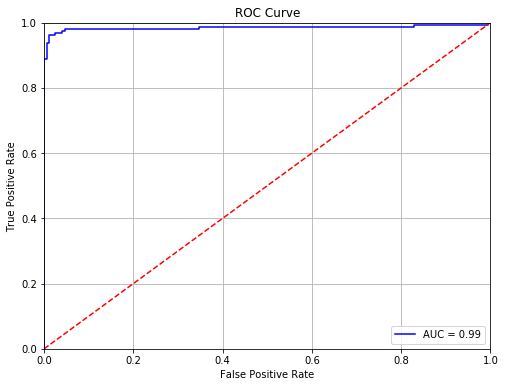

In [82]:
# Import necessary libraries
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, auc

# Initialize metrics
auc_score = 0.
ks = 0.
roc_auc = 0.
recall = 0.
precision = 0.

# Check predicted probabilities
print("Sample probabilities:", y_proba_val[:10])  # First 10 predictions

# Calculate predictions based on a threshold
threshold = 0.5
y_pred = (y_proba_val > threshold).astype(int)

# Check number of positive predictions
print("Number of positive predictions:", np.sum(y_pred))

# Evaluate the target variable distribution
print("Unique values in y_testTf:", np.unique(y_testTf, return_counts=True))

# Check shapes
print("Shape of y_proba_val:", y_proba_val.shape)
print("Shape of y_testTf:", y_testTf.shape)

# Check predictions
threshold = 0.5
y_pred = (y_proba_val > threshold).astype(int)

print("Shape of y_pred:", y_pred.shape)
print("Predicted labels:", y_pred[:10])  # Print first 10 predictions
print("True labels:", y_testTf[:10])     # Print first 10 true labels

# Check number of positive predictions
print("Number of positive predictions on test set:", np.sum(y_pred))

# Ensure y_testTf is a flat array for consistency
y_testTf_flat = y_testTf.flatten()

# Ensure y_proba_val and y_testTf have the same shape
if y_proba_val.shape[0] == y_testTf_flat.shape[0]:
    # Calculate precision and recall
    precision = precision_score(y_testTf_flat, y_pred)
    recall = recall_score(y_testTf_flat, y_pred)
    
    # Calculate AUC score
    auc_score = roc_auc_score(y_testTf_flat, y_proba_val)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_testTf_flat, y_proba_val, pos_label=1)
    
    # Calculate ROC AUC
    roc_auc = auc(fpr, tpr)
    
    # Calculate Kolmogorov-Smirnov statistic
    ks = np.max(tpr - fpr)

    # Print evaluation metrics
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('AUC score: ', auc_score)
    print('ROC AUC: ', roc_auc)
    print('KS statistic: ', ks)

    # Plot ROC curve
    try:
        plt.figure(figsize=(8, 6))
        plt.title('ROC Curve')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line for random chance
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.grid()
        plt.savefig('ROC_curve_TF.png')
        plt.show()
    except Exception as e:
        print("Error while plotting ROC curve:", e)

In [83]:
### GRADED PART (DO NOT EDIT) ###
part_4=list([precision, recall, roc_auc, ks])
try:
    part4 = " ".join(map(repr, part_4))
except TypeError:
    part4 = repr(part_4)
submissions[all_parts[3]]=part4
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:4],all_parts,submissions)
[precision, recall, roc_auc, ks]
### GRADED PART (DO NOT EDIT) ###

Something went wrong, please have a look at the reponse of the grader
-------------------------
{"errorCode":"invalidEmailOrToken","message":"Invalid email or token.","details":null}
-------------------------


[0.96894409937888204,
 0.96894409937888204,
 0.98523931311655089,
 0.95096821337230553]

## Neural Network with Tensorflow

In [34]:
cols = state_cols + MEV_cols
n_inputs = len(cols)

# inputs 
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# outputs 
y_trainTf = df_train['defaulter'].astype('int').values.reshape(-1,)
y_testTf = df_test['defaulter'].astype('int').values.reshape(-1,)

In [35]:
import numpy as np
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        tf.set_random_seed(42)
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

### Construct Neural Network

**Instructions**
Implement Neural Network with two hidden layers. The number of nodes in the first and the second hidden layers is **n_hidden1** and **n_hidden2** correspondingly.
Use neuron_layer() function to construct neural network layers.

- Use ReLU activation function for hidden layers
- The output layer has **n_outputs** and does not have an activation function
- Use sparse softmax cross-entropy with logits as a loss function

In [42]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score

# Hyperparameters
learning_rate = 0.05
n_epochs = 400
batch_size = 50
n_inputs = X_trainTf.shape[1]  # Assuming X_trainTf is already defined
num_rec = X_trainTf.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))

# Reset the graph
tf.reset_default_graph()

# Placeholders for input and output
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

# Function to create a neuron layer
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        weights = tf.Variable(tf.random_normal((n_inputs, n_neurons), stddev=stddev), name='weights')
        biases = tf.Variable(tf.zeros(n_neurons), name='biases')
        Z = tf.matmul(X, weights) + biases
        if activation == 'relu':
            return tf.nn.relu(Z)
        return Z

# Define the neural network
n_hidden1 = 20
n_hidden2 = 10
n_outputs = 2  # Binary classification

# Create the layers
hidden1 = neuron_layer(X, n_hidden1, name='hidden1', activation='relu')
hidden2 = neuron_layer(hidden1, n_hidden2, name='hidden2', activation='relu')
logits = neuron_layer(hidden2, n_outputs, name='output')

# Loss and optimizer
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# Accuracy calculation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.cast(y, tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize all variables
init = tf.global_variables_initializer()

# Training and evaluation
with tf.Session() as sess:
    sess.run(init)  # Initialize variables

    # Training loop
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            # Get the batch of data
            start_index = batch_index * batch_size
            end_index = min(start_index + batch_size, num_rec)
            X_batch = X_trainTf[start_index:end_index]
            y_batch = y_trainTf[start_index:end_index]
            
            # Run the training operation
            sess.run(train_op, feed_dict={X: X_batch, y: y_batch})

    # Evaluate accuracy on the test set
    acc_test = sess.run(accuracy, feed_dict={X: X_testTf, y: y_testTf})

print('Test accuracy: {:.4f}'.format(acc_test))

Test accuracy: 0.9547


### Train Neural Network

**Instructions**
Train neural network passing batches of inputs of size **batch_size**, which predicts bank defaults / non-defaults. Once the network is trained, evaluate accuracy using **X_testTf**, **y_testTf**


In [44]:
import numpy as np
import tensorflow as tf

# Reset the default graph
tf.reset_default_graph()

# Assuming X_trainTf, y_trainTf, X_testTf, and y_testTf are defined
n_inputs = X_trainTf.shape[1]  # Number of features (inputs)
n_classes = 2  # For binary classification (defaults/non-defaults)

# Hyperparameters
learning_rate = 0.05
n_epochs = 400
batch_size = 50
num_rec = X_trainTf.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))
acc_test = 0.  # Variable required for testing accuracy

# Placeholders for input and output
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

# Define the model (logits)
# Example: a simple feedforward neural network
hidden_layer = tf.layers.dense(X, units=10, activation=tf.nn.relu)
logits = tf.layers.dense(hidden_layer, units=n_classes)  # Final output layer

# Loss and optimizer
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# Create an operation to calculate accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.cast(y, tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize all variables
init = tf.global_variables_initializer()

# Training and evaluation
with tf.Session() as sess:
    sess.run(init)  # Initialize variables

    # Training loop
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            # Get the batch of data
            start_index = batch_index * batch_size
            end_index = min(start_index + batch_size, num_rec)
            X_batch = X_trainTf[start_index:end_index]
            y_batch = y_trainTf[start_index:end_index]

            # Run the training operation
            sess.run(train_op, feed_dict={X: X_batch, y: y_batch})

    # Evaluate accuracy on the test set
    acc_test = sess.run(accuracy, feed_dict={X: X_testTf, y: y_testTf})

print('Test accuracy: {:.4f}'.format(acc_test))

Test accuracy: 0.9607


In [45]:
### GRADED PART (DO NOT EDIT) ###
part5=str(acc_test)
submissions[all_parts[4]]=part5
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:5],all_parts,submissions)
acc_test
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


0.96072507